## This notebook looks at exploring hyperspectral data
- We create a RGB plot of the hyperspectral data.  
- We add support for plotting the spectral signature of a random point.  
- We add support for plotting the random point on an interactive map with the extent (bounding box)of the hyperspectral data.  

### Step 1: Import the required libraries

In [ ]:
import ee
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import numbers as np

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


### Step 2: Read in the hyperspectral data

In [ ]:
# This is a cleaned version of the data, after removing the atmospheric contaminated regions.
ds = xr.open_zarr('/mnt/hdd1/fran/fran_sep2018_clean.zarr')
ds


<xarray.Dataset> Size: 65GB
Dimensions:      (wl: 202, x: 16310, y: 9885)
Coordinates:
  * wl           (wl) float64 2kB 0.4066 0.4134 0.4201 ... 1.983 1.989 1.996
  * x            (x) float64 130kB 3.14e+05 3.14e+05 ... 3.629e+05 3.629e+05
  * y            (y) float64 79kB 6.266e+06 6.266e+06 ... 6.237e+06 6.237e+06
Data variables:
    reflectance  (wl, x, y) int16 65GB ...

In [ ]:
# Plot the wavelengths of the data
ds.wl.to_numpy()

array([0.40661, 0.41337, 0.42013, 0.42689, 0.43367, 0.44044, 0.44723,
       0.45402, 0.46082, 0.46762, 0.47442, 0.48123, 0.48805, 0.49487,
       0.5017 , 0.50852, 0.51536, 0.52219, 0.52904, 0.53589, 0.54274,
       0.54959, 0.55645, 0.56331, 0.57017, 0.57704, 0.58391, 0.59078,
       0.59766, 0.60454, 0.61142, 0.6183 , 0.62519, 0.63208, 0.63897,
       0.64586, 0.65276, 0.65965, 0.66654, 0.67344, 0.68035, 0.68725,
       0.69414, 0.70104, 0.70795, 0.71485, 0.72176, 0.72866, 0.73556,
       0.74247, 0.74937, 0.75627, 0.76318, 0.77008, 0.77698, 0.78388,
       0.79078, 0.79768, 0.80458, 0.81148, 0.81837, 0.82526, 0.83216,
       0.83905, 0.84594, 0.85282, 0.85971, 0.86659, 0.87347, 0.88034,
       0.88722, 0.89409, 0.90095, 0.90781, 0.91468, 0.92153, 0.92839,
       0.93524, 0.94209, 0.94892, 0.95576, 0.9626 , 0.96943, 0.97271,
       0.97905, 0.98538, 0.99172, 0.99805, 1.00439, 1.01072, 1.01705,
       1.02339, 1.02972, 1.03605, 1.04238, 1.04871, 1.05504, 1.06137,
       1.0677 , 1.07

### Step 3: Plot RGB

In [6]:
# Select bands for RGB by choosing specific wavelengths
# Adjust wl values as per your dataset's range
red_band = ds.sel(wl=650, method="nearest")  # Red: ~650 nm
green_band = ds.sel(wl=550, method="nearest")  # Green: ~550 nm
blue_band = ds.sel(wl=470, method="nearest")  # Blue: ~470 nm

# Normalize each band to 0-1 range for visualization
def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

red = normalize(red_band)
green = normalize(green_band)
blue = normalize(blue_band)

# Stack bands along a new dimension named 'rgb'
rgb_stack = xr.concat([red, green, blue], dim="rgb")
rgb_stack = rgb_stack.assign_coords(rgb=["red", "green", "blue"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


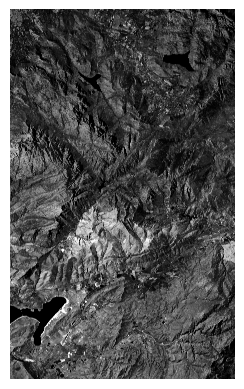

In [ ]:
# Select a 256x256 patch, adjusting the indices as needed
patch = rgb_stack.isel(y=slice(100, 356), x=slice(200, 456))

# Convert to numpy array for plotting
rgb_array = rgb_stack.to_array().squeeze().values.transpose(1, 2, 0)*3  # Transpose to (y, x, band)

# .plot.imshow(rgb="band")
# Display the patch
plt.imshow(rgb_array, vmin=0, vmax=.25)
plt.axis('off')  # Remove axis labels
plt.show()

### Step 4: Plot the spectral signature of a random point

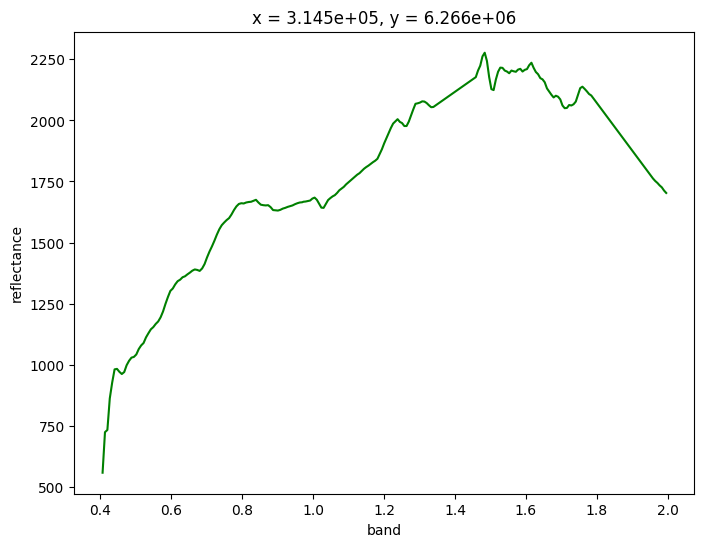

In [103]:
import xarray as xr
import matplotlib.pyplot as plt
import random  # For random point selection

# Assuming 'rgb_stack' is your xarray Dataset
# Generate random coordinates within valid range
y_random = random.choice(ds.y.to_numpy())
x_random = random.choice(ds.x.to_numpy())

# Select the spectral signature at the random point
spectral_signature = ds.sel(y=y_random, x=x_random, method='nearest')

spectral_signature['reflectance'].plot.line(color = 'g')
plt.rcParams['figure.figsize'] = [8,6]
plt.xlabel("band")
plt.ylabel("reflectance")
plt.show()

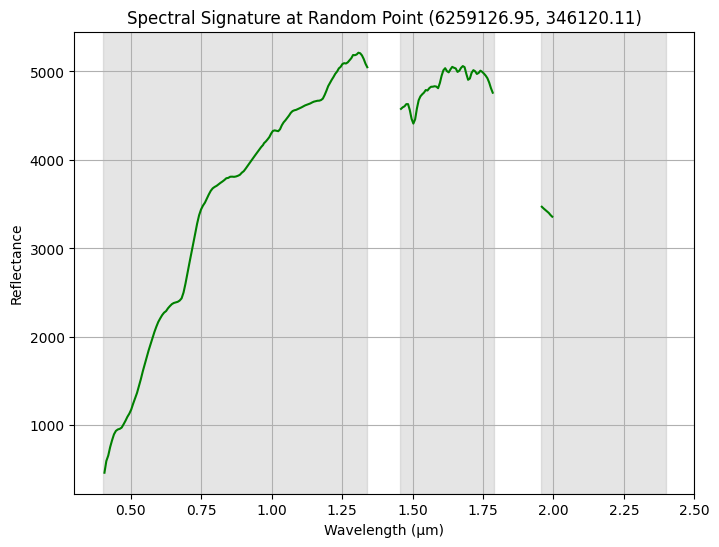

In [ ]:
# Plot spectral signature- accomodate breaks because of atmospheric conditions
import xarray as xr
import matplotlib.pyplot as plt
import random
import numpy as np

def plot_spectral_signature_with_gaps(ds):
    # Define the atmospheric windows
    windows = [
        (0.400, 1.340),
        (1.455, 1.790),
        (1.955, 2.400)
    ]

    # Create arrays for dummy points
    dummy_wavelengths = []
    dummy_reflectance = []

    # Loop through each window and create dummy points
    for start, end in windows:
        dummy_wavelengths.extend([start - 0.01, end + 0.01])
        dummy_reflectance.extend([np.nan, np.nan])

    # Create a new dataset with dummy points
    dummy_ds = xr.Dataset({
        'reflectance': ('band', dummy_reflectance),
    }, coords={
        'band': range(len(dummy_wavelengths)),
        'wl': ('band', dummy_wavelengths)
    })

    # Generate random coordinates within valid range
    y_random = random.choice(ds.y.values)
    x_random = random.choice(ds.x.values)

    # Select the spectral signature at the random point
    original_signature = ds.sel(y=y_random, x=x_random, method='nearest')

    # Create a similar structure for the original data
    original_ds = xr.Dataset({
        'reflectance': ('band', original_signature.reflectance.values),
    }, coords={
        'band': range(len(original_signature.reflectance)),
        'wl': ('band', original_signature.wl.values)
    })

    # Concatenate along the band dimension
    combined_ds = xr.concat([original_ds, dummy_ds], dim='band')

    # Sort by wavelength
    combined_ds = combined_ds.sortby('wl')

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(combined_ds.wl, combined_ds.reflectance, 'g-')
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Reflectance")
    plt.title(f"Spectral Signature at Random Point ({y_random:.2f}, {x_random:.2f})")
    
    # Add shaded regions for atmospheric windows
    ymin, ymax = plt.ylim()
    for start, end in windows:
        plt.axvspan(start, end, color='gray', alpha=0.2)
    
    plt.grid(True)
    plt.show()
    
    return y_random, x_random

# Usage:
y, x = plot_spectral_signature_with_gaps(ds)

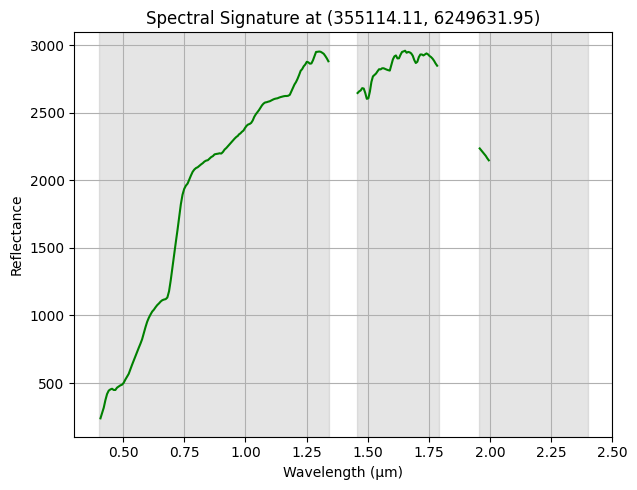

In [ ]:
# Add a interactive map that displays the random point
import xarray as xr
import matplotlib.pyplot as plt
import random
import numpy as np
import leafmap.foliumap as leafmap
from pyproj import Transformer
import folium

def plot_spectral_and_map(ds, crs_from='EPSG:32610', crs_to='EPSG:4326'):
    """
    Plot both spectral signature and location map for a random point.
    
    Parameters:
    ds: xarray Dataset containing spectral data
    crs_from: The CRS of your input coordinates (default UTM Zone 10N)
    crs_to: The target CRS (default WGS84)
    """
    # First create the spectral signature plot
    # Define the atmospheric windows
    windows = [
        (0.400, 1.340),
        (1.455, 1.790),
        (1.955, 2.400)
    ]

    # Create arrays for dummy points
    dummy_wavelengths = []
    dummy_reflectance = []

    # Loop through each window and create dummy points
    for start, end in windows:
        dummy_wavelengths.extend([start - 0.01, end + 0.01])
        dummy_reflectance.extend([np.nan, np.nan])

    # Create a new dataset with dummy points
    dummy_ds = xr.Dataset({
        'reflectance': ('band', dummy_reflectance),
    }, coords={
        'band': range(len(dummy_wavelengths)),
        'wl': ('band', dummy_wavelengths)
    })

    # Generate random coordinates within valid range
    y_random = random.choice(ds.y.values)
    x_random = random.choice(ds.x.values)

    # Select the spectral signature at the random point
    original_signature = ds.sel(y=y_random, x=x_random, method='nearest')

    # Create a similar structure for the original data
    original_ds = xr.Dataset({
        'reflectance': ('band', original_signature.reflectance.values),
    }, coords={
        'band': range(len(original_signature.reflectance)),
        'wl': ('band', original_signature.wl.values)
    })

    # Concatenate along the band dimension
    combined_ds = xr.concat([original_ds, dummy_ds], dim='band')
    combined_ds = combined_ds.sortby('wl')

    # Create subplot layout
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    # Plot spectral signature
    plt.plot(combined_ds.wl, combined_ds.reflectance, 'g-')
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Reflectance")
    plt.title(f"Spectral Signature at ({x_random:.2f}, {y_random:.2f})")
    
    # Add shaded regions for atmospheric windows
    ymin, ymax = plt.ylim()
    for start, end in windows:
        plt.axvspan(start, end, color='gray', alpha=0.2)
    plt.grid(True)
    
    # Convert coordinates to lat/lon
    transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
    lon, lat = transformer.transform(x_random, y_random)
    
    # Create leafmap
    m = leafmap.Map(
        center=[lat, lon],
        zoom=15,
        draw_control=False,
        measure_control=False,
        fullscreen_control=False,
    )
    
    # Add a marker for the random point
    folium.Marker(
        [lat, lon],
        popup=f'Spectral Sample Point<br>Coordinates: ({x_random:.2f}, {y_random:.2f})',
        icon=folium.Icon(color='green')
    ).add_to(m)
    
    # Add satellite basemap
    m.add_basemap('SATELLITE')
    
    # Display both plots
    plt.tight_layout()
    plt.show()
    display(m)
    
    return x_random, y_random, lat, lon

# Usage example:
x, y, lat, lon = plot_spectral_and_map(ds, crs_from='EPSG:22234')

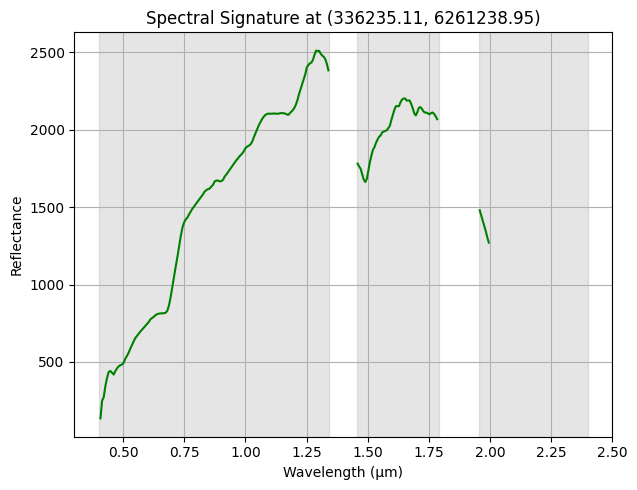

In [ ]:
# Add a interactive map that displays the random point, and shows the extent of the hyperspectral data.

import xarray as xr
import matplotlib.pyplot as plt
import random
import numpy as np
import leafmap.foliumap as leafmap
from pyproj import Transformer
import folium

def plot_spectral_and_map(ds, crs_from='EPSG:32610', crs_to='EPSG:4326'):
    """
    Plot both spectral signature and location map for a random point, including a bounding box.
    
    Parameters:
    ds: xarray Dataset containing spectral data
    crs_from: The CRS of your input coordinates (default UTM Zone 10N)
    crs_to: The target CRS (default WGS84)
    """
    # First create the spectral signature plot
    # Define the atmospheric windows
    windows = [
        (0.400, 1.340),
        (1.455, 1.790),
        (1.955, 2.400)
    ]

    # Create arrays for dummy points
    dummy_wavelengths = []
    dummy_reflectance = []

    # Loop through each window and create dummy points
    for start, end in windows:
        dummy_wavelengths.extend([start - 0.01, end + 0.01])
        dummy_reflectance.extend([np.nan, np.nan])

    # Create a new dataset with dummy points
    dummy_ds = xr.Dataset({
        'reflectance': ('band', dummy_reflectance),
    }, coords={
        'band': range(len(dummy_wavelengths)),
        'wl': ('band', dummy_wavelengths)
    })

    # Generate random coordinates within valid range
    y_random = random.choice(ds.y.values)
    x_random = random.choice(ds.x.values)

    # Select the spectral signature at the random point
    original_signature = ds.sel(y=y_random, x=x_random, method='nearest')

    # Create a similar structure for the original data
    original_ds = xr.Dataset({
        'reflectance': ('band', original_signature.reflectance.values),
    }, coords={
        'band': range(len(original_signature.reflectance)),
        'wl': ('band', original_signature.wl.values)
    })

    # Concatenate along the band dimension
    combined_ds = xr.concat([original_ds, dummy_ds], dim='band')
    combined_ds = combined_ds.sortby('wl')

    # Create subplot layout
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    # Plot spectral signature
    plt.plot(combined_ds.wl, combined_ds.reflectance, 'g-')
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Reflectance")
    plt.title(f"Spectral Signature at ({x_random:.2f}, {y_random:.2f})")
    
    # Add shaded regions for atmospheric windows
    ymin, ymax = plt.ylim()
    for start, end in windows:
        plt.axvspan(start, end, color='gray', alpha=0.2)
    plt.grid(True)
    
    # Convert coordinates to lat/lon
    transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
    lon, lat = transformer.transform(x_random, y_random)
    
    # Create leafmap
    m = leafmap.Map(
        center=[lat, lon],
        zoom=15,
        draw_control=False,
        measure_control=False,
        fullscreen_control=False,
        basemap = 'Esri.WorldImagery'
    )
    
    # Add a marker for the random point
    folium.Marker(
        [lat, lon],
        popup=f'Spectral Sample Point<br>Coordinates: ({x_random:.2f}, {y_random:.2f})',
        icon=folium.Icon(color='green')
    ).add_to(m)
    
    # Add satellite basemap
    m.add_basemap('SATELLITE')
    m.add_basemap('Esri.WorldImagery')
    m.add_basemap('ESA WorldCover 2021')
    

    # Add a bounding box around the dataset in red
    # Assuming that the x and y values represent the bounds of the area
    x_min, x_max = ds.x.min(), ds.x.max()
    y_min, y_max = ds.y.min(), ds.y.max()

    # Convert bounding box corners to lat/lon
    lon_min, lat_min = transformer.transform(x_min, y_min)
    lon_max, lat_max = transformer.transform(x_max, y_max)

    # Create a rectangle for the bounding box
    folium.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color='red',
        weight=2,
        fill=False
    ).add_to(m)
    
    # Display both plots
    plt.tight_layout()
    plt.show()
    display(m)
    
    return x_random, y_random, lat, lon

# Usage example:
x, y, lat, lon = plot_spectral_and_map(ds, crs_from='EPSG:22234')


AttributeError: 'Map' object has no attribute 'on_click'

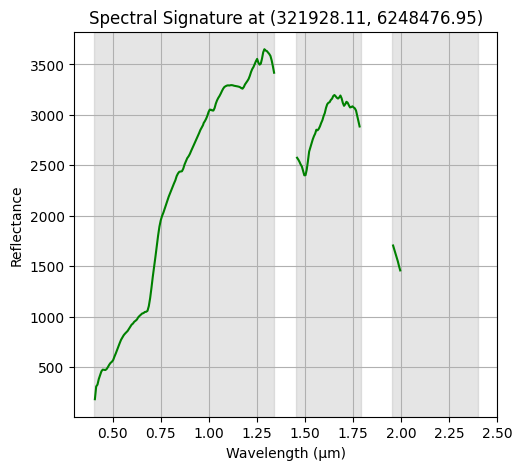

In [ ]:
# Experimental- add interactivity. click to add point and get spectral signature
import xarray as xr
import matplotlib.pyplot as plt
import random
import numpy as np
import folium
from pyproj import Transformer

def plot_spectral_and_map(ds, crs_from='EPSG:32610', crs_to='EPSG:4326'):
    """
    Plot both spectral signature and location map for a random point and allow interactive clicks to plot spectral signatures.
    
    Parameters:
    ds: xarray Dataset containing spectral data
    crs_from: The CRS of your input coordinates (default UTM Zone 10N)
    crs_to: The target CRS (default WGS84)
    """
    # First create the spectral signature plot
    # Define the atmospheric windows
    windows = [
        (0.400, 1.340),
        (1.455, 1.790),
        (1.955, 2.400)
    ]

    # Create arrays for dummy points
    dummy_wavelengths = []
    dummy_reflectance = []

    # Loop through each window and create dummy points
    for start, end in windows:
        dummy_wavelengths.extend([start - 0.01, end + 0.01])
        dummy_reflectance.extend([np.nan, np.nan])

    # Create a new dataset with dummy points
    dummy_ds = xr.Dataset({
        'reflectance': ('band', dummy_reflectance),
    }, coords={
        'band': range(len(dummy_wavelengths)),
        'wl': ('band', dummy_wavelengths)
    })

    # Generate random coordinates within valid range
    y_random = random.choice(ds.y.values)
    x_random = random.choice(ds.x.values)

    # Select the spectral signature at the random point
    original_signature = ds.sel(y=y_random, x=x_random, method='nearest')

    # Create a similar structure for the original data
    original_ds = xr.Dataset({
        'reflectance': ('band', original_signature.reflectance.values),
    }, coords={
        'band': range(len(original_signature.reflectance)),
        'wl': ('band', original_signature.wl.values)
    })

    # Concatenate along the band dimension
    combined_ds = xr.concat([original_ds, dummy_ds], dim='band')
    combined_ds = combined_ds.sortby('wl')

    # Create subplot layout
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    # Plot initial spectral signature
    plt.plot(combined_ds.wl, combined_ds.reflectance, 'g-')
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Reflectance")
    plt.title(f"Spectral Signature at ({x_random:.2f}, {y_random:.2f})")
    
    # Add shaded regions for atmospheric windows
    ymin, ymax = plt.ylim()
    for start, end in windows:
        plt.axvspan(start, end, color='gray', alpha=0.2)
    plt.grid(True)

    # Convert coordinates to lat/lon
    transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
    lon, lat = transformer.transform(x_random, y_random)
    
    # Create folium map centered around the random point
    m = folium.Map(location=[lat, lon], zoom_start=15)

    # Store the previous spectral signatures (for multiple clicks)
    spectral_signatures = []

    # Function to handle the click and plot spectral signature
    def on_map_click(e):
        # Get lat/lon from the click event
        lat_click, lon_click = e.latlng

        # Convert lat/lon to original CRS (from lat/lon)
        x_click, y_click = transformer.transform(lon_click, lat_click, inverse=True)

        # Select the spectral signature at the clicked point
        clicked_signature = ds.sel(y=y_click, x=x_click, method='nearest')

        # Create a similar structure for the clicked data
        clicked_ds = xr.Dataset({
            'reflectance': ('band', clicked_signature.reflectance.values),
        }, coords={
            'band': range(len(clicked_signature.reflectance)),
            'wl': ('band', clicked_signature.wl.values)
        })

        # Add to the list of spectral signatures
        spectral_signatures.append(clicked_ds)

        # Clear the existing plot and plot all signatures
        plt.subplot(1, 2, 1)
        plt.cla()  # Clear axis
        for signature in spectral_signatures:
            plt.plot(signature.wl, signature.reflectance, 'g-', alpha=0.7)

        # Update the plot title with the last clicked point
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Reflectance")
        plt.title(f"Spectral Signature at ({x_click:.2f}, {y_click:.2f})")

        # Add shaded regions for atmospheric windows
        ymin, ymax = plt.ylim()
        for start, end in windows:
            plt.axvspan(start, end, color='gray', alpha=0.2)
        plt.grid(True)
        
        plt.draw()

    # Add a click event to the folium map to call the handler
    m.on_click(on_map_click)

    # Add a marker for the random point
    folium.Marker(
        [lat, lon],
        popup=f'Spectral Sample Point<br>Coordinates: ({x_random:.2f}, {y_random:.2f})',
        icon=folium.Icon(color='green')
    ).add_to(m)
    
    # Add satellite basemap
    m.add_child(folium.TileLayer('cartodb positron'))

    # Add a bounding box around the dataset in red
    x_min, x_max = ds.x.min(), ds.x.max()
    y_min, y_max = ds.y.min(), ds.y.max()

    # Convert bounding box corners to lat/lon
    lon_min, lat_min = transformer.transform(x_min, y_min)
    lon_max, lat_max = transformer.transform(x_max, y_max)

    # Create a rectangle for the bounding box
    folium.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color='red',
        weight=2,
        fill=False
    ).add_to(m)
    
    # Display both plots
    plt.tight_layout()
    plt.show()
    display(m)
    
    return x_random, y_random, lat, lon

# Usage example:
x, y, lat, lon = plot_spectral_and_map(ds, crs_from='EPSG:22234')


In [20]:
for basemap in leafmap.basemaps.keys():
    print(basemap)

OpenStreetMap
ROADMAP
SATELLITE
TERRAIN
HYBRID
FWS NWI Wetlands
FWS NWI Wetlands Raster
NLCD 2021 CONUS Land Cover
NLCD 2019 CONUS Land Cover
NLCD 2016 CONUS Land Cover
NLCD 2013 CONUS Land Cover
NLCD 2011 CONUS Land Cover
NLCD 2008 CONUS Land Cover
NLCD 2006 CONUS Land Cover
NLCD 2004 CONUS Land Cover
NLCD 2001 CONUS Land Cover
USGS NAIP Imagery
USGS NAIP Imagery False Color
USGS NAIP Imagery NDVI
USGS Hydrography
USGS 3DEP Elevation
USGS 3DEP Elevation Index
ESA WorldCover 2020
ESA WorldCover 2020 S2 FCC
ESA WorldCover 2020 S2 TCC
ESA WorldCover 2021
ESA WorldCover 2021 S2 FCC
ESA WorldCover 2021 S2 TCC
BaseMapDE.Color
BaseMapDE.Grey
BasemapAT.basemap
BasemapAT.grau
BasemapAT.highdpi
BasemapAT.orthofoto
BasemapAT.overlay
BasemapAT.surface
BasemapAT.terrain
CartoDB.DarkMatter
CartoDB.DarkMatterNoLabels
CartoDB.DarkMatterOnlyLabels
CartoDB.Positron
CartoDB.PositronNoLabels
CartoDB.PositronOnlyLabels
CartoDB.Voyager
CartoDB.VoyagerLabelsUnder
CartoDB.VoyagerNoLabels
CartoDB.VoyagerOnlyL